In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("bull_train.csv", low_memory=False, parse_dates=["saledate"])

In [3]:
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


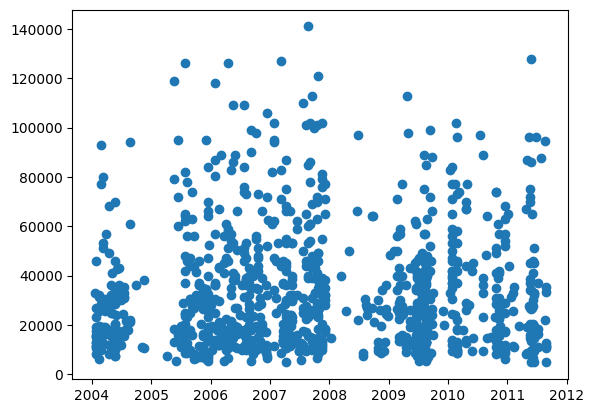

In [4]:
fig, ax = plt.subplots()

ax.scatter(data["saledate"][:1000], data["SalePrice"][:1000]);

In [5]:
data.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [6]:
data.sort_values(by="saledate", ascending=True, inplace=True)

In [7]:
data.saledate.head(10)

205615   1989-01-17
92803    1989-01-31
98346    1989-01-31
169297   1989-01-31
274835   1989-01-31
75378    1989-01-31
81383    1989-01-31
134080   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [8]:
df = data.copy()

In [9]:
df["dayOfYear"] = df.saledate.dt.dayofyear
df["Year"] = df.saledate.dt.year
df["Day"] = df.saledate.dt.day
df["Month"] = df.saledate.dt.month
df["startOfQuarter"] = df.saledate.dt.is_quarter_start
df["endOfQuarter"] = df.saledate.dt.is_quarter_end

In [10]:
df.drop("saledate", inplace=True, axis=1)

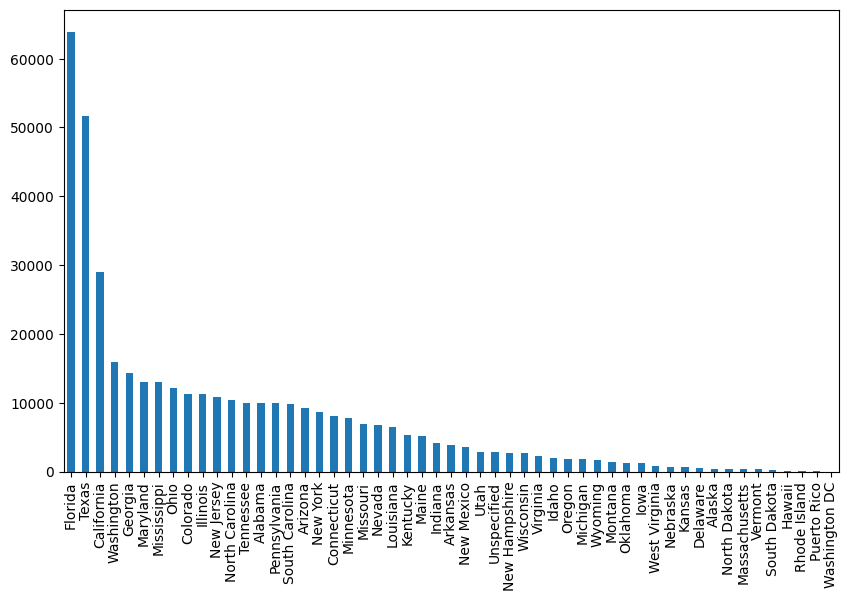

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

df.state.value_counts().plot(kind="bar");

In [12]:
# Converting Object/String Columns in Pandas Categories (Similar to Label Encoding but uses Hash Tables instead of Sorted Search)

for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   401125 non-null  int64   
 1   SalePrice                 401125 non-null  int64   
 2   MachineID                 401125 non-null  int64   
 3   ModelID                   401125 non-null  int64   
 4   datasource                401125 non-null  int64   
 5   auctioneerID              380989 non-null  float64 
 6   YearMade                  401125 non-null  int64   
 7   MachineHoursCurrentMeter  142765 non-null  float64 
 8   UsageBand                 69639 non-null   category
 9   fiModelDesc               401125 non-null  category
 10  fiBaseModel               401125 non-null  category
 11  fiSecondaryDesc           263934 non-null  category
 12  fiModelSeries             56908 non-null   category
 13  fiModelDescriptor       

In [14]:
df.state.cat.codes

205615    43
92803      8
98346      8
169297     8
274835     8
          ..
393123    31
397987    31
392664    31
400458    31
400217    31
Length: 401125, dtype: int8

In [15]:
# df.isna().sum()/len(df)

In [16]:
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if df[label].isna().sum():
            df[label+"is_missing"] = pd.isnull(content)
            
            df[label] = content.fillna(content.median())

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 60 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   SalesID                             401125 non-null  int64   
 1   SalePrice                           401125 non-null  int64   
 2   MachineID                           401125 non-null  int64   
 3   ModelID                             401125 non-null  int64   
 4   datasource                          401125 non-null  int64   
 5   auctioneerID                        401125 non-null  float64 
 6   YearMade                            401125 non-null  int64   
 7   MachineHoursCurrentMeter            401125 non-null  float64 
 8   UsageBand                           69639 non-null   category
 9   fiModelDesc                         401125 non-null  category
 10  fiBaseModel                         401125 non-null  category
 11  fiSecond

In [18]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label+"is_missing"] = pd.isnull(content)
        
        df[label] = df[label].cat.codes + 1

In [19]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Data columns (total 104 columns):
 #    Column                              Non-Null Count   Dtype  
---   ------                              --------------   -----  
 0    SalesID                             401125 non-null  int64  
 1    SalePrice                           401125 non-null  int64  
 2    MachineID                           401125 non-null  int64  
 3    ModelID                             401125 non-null  int64  
 4    datasource                          401125 non-null  int64  
 5    auctioneerID                        401125 non-null  float64
 6    YearMade                            401125 non-null  int64  
 7    MachineHoursCurrentMeter            401125 non-null  float64
 8    UsageBand                           401125 non-null  int8   
 9    fiModelDesc                         401125 non-null  int16  
 10   fiBaseModel                         401125 non-null  int16  
 11   fiSeco

In [20]:
df.Year

205615    1989
92803     1989
98346     1989
169297    1989
274835    1989
          ... 
393123    2011
397987    2011
392664    2011
400458    2011
400217    2011
Name: Year, Length: 401125, dtype: int64

In [21]:
df_train = df[df.Year != 2011]
df_val = df[df.Year == 2011]

In [22]:
len(df_train), len(df_val)

(365928, 35197)

In [23]:
X_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]

X_test = df_val.drop("SalePrice", axis=1)
y_test = df_val["SalePrice"]

In [47]:
%%time

model = RandomForestRegressor(n_estimators=100, verbose=2, max_samples=10000, n_jobs=-1)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


RandomForestRegressor(max_samples=10000, n_jobs=-1, verbose=2)

In [58]:
def scores(model):
    y_pred = model.predict(X_test)
    
    score_dict = {"Training R^2": model.score(X_train, y_train),
                  "Valid R^2": model.score(X_test, y_test),
                  "MAE": mean_absolute_error(y_test, y_pred),
                  "MSE": mean_squared_error(y_test, y_pred),
                  "RMSLE": np.sqrt(mean_squared_log_error(y_test, y_pred))}
    
    return score_dict

In [59]:
scores(model)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


{'Training R^2': 0.8634640203472935,
 'Valid R^2': 0.8178994435383906,
 'MAE': 6877.579188851322,
 'MSE': 112611941.48717405,
 'RMSLE': 0.28549218424549405}